In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.nn import functional as F
import torch.autograd as autograd

In [49]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias).float()

        self.physics_conv = nn.Conv2d(in_channels=self.input_dim,
                                      out_channels=4 * self.hidden_dim,
                                      kernel_size=self.kernel_size,
                                      padding=self.padding,
                                      bias=False).float()
        
        

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        # Check if input_tensor has an extra dimension (sequence length)
        if input_tensor.dim() == 5:
            input_tensor = input_tensor.squeeze(1)

        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        physics_conv = self.physics_conv(input_tensor)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        pc_i, pc_f, pc_o, pc_g = torch.split(physics_conv, self.hidden_dim, dim=1)

        i = torch.sigmoid(cc_i + pc_i)
        f = torch.sigmoid(cc_f + pc_f)
        o = torch.sigmoid(cc_o + pc_o)
        g = torch.tanh(cc_g + pc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM_iPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,output_dim,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM_iPINN, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

        # Initialize velocities as trainable parameters
        self.velocity_x = nn.Parameter(torch.tensor(0.1))
        self.velocity_y = nn.Parameter(torch.tensor(0.1))

        self.output_conv = nn.Conv2d(in_channels=hidden_dim[-1],
                                      out_channels=output_dim,
                                      kernel_size=1,
                                      padding=0)

    def forward(self, input_tensor, hidden_state=None):
        if input_tensor.dim() == 4:
            # (b, h, w, c) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(0, 3, 1, 2).unsqueeze(1)
        elif input_tensor.dim() == 5:
            if not self.batch_first:
                # (t, b, c, h, w) -> (b, t, c, h, w)
                input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, t, _, h, w = input_tensor.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        # Remove the sequence length dimension before applying the output convolution
        output = self.output_conv(layer_output_list[0].squeeze(1))
        # Permute the output to have shape (b, h, w, c)
        output = output.permute(0, 2, 3, 1)
        return output, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

    def advection_loss(self, input_tensor, output_tensor):
        grad = torch.autograd.grad(outputs=output_tensor, inputs=input_tensor,
                                   grad_outputs=torch.ones_like(output_tensor), create_graph=True)[0]
        dudx = grad[:, :, 0]
        dudy = grad[:, :, 1]
        dudt = grad[:, :, 2]

        physics = dudt + self.velocity_x * dudx + self.velocity_y * dudy
        loss = torch.mean((physics) ** 2)

        return loss

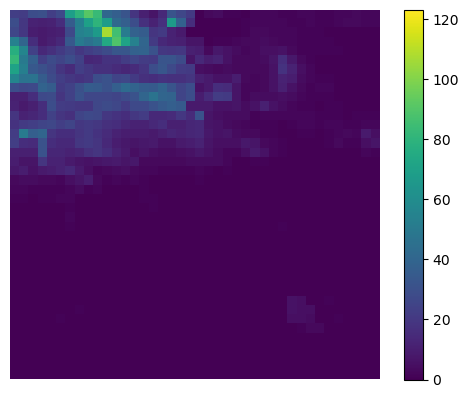

/home/sushen/anaconda3/envs/pinn/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


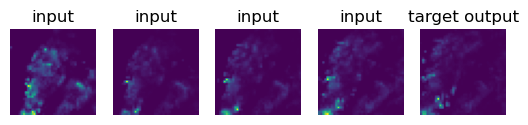

In [30]:
# load radar data
movies = np.load('data/radar_movies.npy')
movies.shape # (980, 40, 40, 20) -- here each movie is of length 20

# in our model we will use the first four images as inputs and predict the
# fifth image
x = movies[:, :, :,  :4]
y = movies[:, :, :, 4:5]


# function: animation of a sequence of radar data (shape = nx,ny,ntime)
def animate(x):
  fig, ax = plt.subplots()
  vmax = np.max(x)
  im = ax.imshow(x[:,:,0], vmin=0, vmax=vmax)
  fig.colorbar(im)
  plt.axis('off')
  def anim_(i):
      im.set_data(x[:,:,i])
      ax.set_title(str(i+1) + '/' + str(x.shape[2]))
  anim = animation.FuncAnimation(
      fig, anim_, interval=300, frames=x.shape[2], repeat_delay=1000)
  plt.show()

# i_plt = 340
# i_plt = 123
i_plt = np.int32(np.random.sample() * movies.shape[0])
animate(x[i_plt,:,:,:])
plt.show()

# train validate test split
tvt = np.tile(['train','train','train','validate','test'], y.shape[0])[:y.shape[0]]
x_train = x[np.where(tvt == 'train')]
y_train = y[np.where(tvt == 'train')]
x_validate = x[np.where(tvt == 'validate')]
y_validate = y[np.where(tvt == 'validate')]
x_test = x[np.where(tvt == 'test')]
y_test = y[np.where(tvt == 'test')]

n_test = x_test.shape[0]
i_plt = np.int32(np.random.sample() * n_test)
true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
# plot an input/output pair
i_plt = 20
i_plt = np.int32(np.random.sample() * x_train.shape[0])
for jj in range(4):
  plt.subplot(1,5,jj+1)
  plt.imshow(x_train[i_plt,:,:,jj])
  plt.axis('off')
  plt.title('input')
plt.subplot(1,5,5)
plt.imshow(y_train[i_plt,:,:,0])
plt.title('target output')
plt.axis('off')
plt.show()

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming x_train, x_validate, x_test, y_train, y_validate, and y_test are defined
print("x_train shape:", np.shape(x_train))
print("x_validate shape:", np.shape(x_validate))
print("x_test shape:", np.shape(x_test))
print("y_train shape:", np.shape(y_train))
print("y_validate shape:", np.shape(y_validate))
print("y_test shape:", np.shape(y_test))

device = torch.device("cuda")

train_dataset = TensorDataset(torch.from_numpy(x_train).float().requires_grad_(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(x_validate).float().requires_grad_(), torch.from_numpy(y_validate).float())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(x_test).float().requires_grad_(), torch.from_numpy(y_test).float())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ConvLSTM_iPINN(input_dim=4, hidden_dim=40, kernel_size=(3, 3), num_layers=3, output_dim=1, bias=True, return_all_layers=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(batch_x)
        output = output.squeeze(1)
        # Enable gradients for the output tensor
        output.requires_grad_(True)
        
        # Compute data loss
        
        data_loss = criterion(output, batch_y)
        
        # Compute physics loss
        physics_loss = model.advection_loss(batch_x, output)
        
        # Combine losses
        loss = data_loss + physics_loss
        
        # Backward pass
        loss.backward()
        
        # Update weights and velocities
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            output, _ = model(batch_x)
            output = output.squeeze(1)
            
            # Compute data loss
            data_loss = criterion(output, batch_y)
            
            
            
            # Combine losses
            loss = data_loss 
            
            val_loss += loss.item() * batch_x.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Testing loop
model.eval()
test_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
       
        # Forward pass
        output, _ = model(batch_x)
        output = output.squeeze(1)
        
        # Compute data loss
        data_loss = criterion(output, batch_y)
        
        # Combine losses
        loss = data_loss 
        
        test_loss += loss.item() * batch_x.size(0)

test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

x_train shape: (588, 40, 40, 4)
x_validate shape: (196, 40, 40, 4)
x_test shape: (196, 40, 40, 4)
y_train shape: (588, 40, 40, 1)
y_validate shape: (196, 40, 40, 1)
y_test shape: (196, 40, 40, 1)
Epoch [1/50]
Train Loss: 946.4888, Val Loss: 1046.9624
Epoch [2/50]
Train Loss: 917.5080, Val Loss: 1035.7931
Epoch [3/50]
Train Loss: 906.4701, Val Loss: 1025.5778
Epoch [4/50]
Train Loss: 896.4812, Val Loss: 1015.3994
Epoch [5/50]
Train Loss: 887.2877, Val Loss: 1005.8755
Epoch [6/50]
Train Loss: 878.7632, Val Loss: 996.9905
Epoch [7/50]
Train Loss: 870.5133, Val Loss: 988.7302
Epoch [8/50]
Train Loss: 862.8091, Val Loss: 980.8233
Epoch [9/50]
Train Loss: 855.2471, Val Loss: 973.0847
Epoch [10/50]
Train Loss: 848.1605, Val Loss: 966.4079
Epoch [11/50]
Train Loss: 841.6458, Val Loss: 958.8755
Epoch [12/50]
Train Loss: 834.7841, Val Loss: 952.1139
Epoch [13/50]
Train Loss: 828.2816, Val Loss: 945.8024
Epoch [14/50]
Train Loss: 821.9211, Val Loss: 938.2654
Epoch [15/50]
Train Loss: 815.6922, Va

In [70]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image
import matplotlib.colors as mcolors
import os
import csv

def animate2(x1, x2, i_plt, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    vmax = np.max(np.append(x1, x2))
    vmin = np.min(np.append(x1, x2))

    frames = min(x1.shape[2], x2.shape[2])  # Get the minimum number of frames

    # Initialize lists to store MAE and RMSE for each frame
    mae_list = []
    rmse_list = []

    for i in range(frames):
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Adjust the figure size as needed

        im1 = ax[0].imshow(x1[:, :, i], vmin=vmin, vmax=vmax)
        im2 = ax[1].imshow(x2[:, :, i], vmin=vmin, vmax=vmax)

        diff = x1[:, :, i] - x2[:, :, i]
        vmin_diff, vmax_diff = np.min(diff), np.max(diff)
        norm = mcolors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
        im3 = ax[2].imshow(diff, cmap='viridis', norm=norm)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im3, cax=cbar_ax)

        # Add labels
        ax[0].set_title('Predicted')
        ax[1].set_title('True')
        ax[2].set_title('Difference')

        # Remove axis ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Calculate MAE and RMSE for the current frame
        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(np.mean(diff ** 2))

        # Append MAE and RMSE to the lists
        mae_list.append(mae)
        rmse_list.append(rmse)

        # Add MAE and RMSE to the plot title
        fig.suptitle(f'Physics informed ConvLSTM | i = {i_plt} Predict Frame - MAE: {mae:.4f}, RMSE: {rmse:.4f}', fontsize=12)

        # Save the current frame as an image file
        filename = f'PhyConvLSTMframe_{i_plt:04d}_{i+1:04d}.png'
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)

        plt.close(fig)

    # # Save MAE and RMSE for each frame to a CSV file
    # csv_file = os.path.join(output_folder, f'mae_rmse_{i_plt:04d}.csv')
    # with open(csv_file, mode='w', newline='') as file:
    #     writer = csv.writer(file)
    #     writer.writerow(['Frame', 'MAE', 'RMSE'])
    #     for i in range(frames):
    #         writer.writerow([i+1, mae_list[i], rmse_list[i]])

    print(f"Images and CSV file saved in the folder: {output_folder}")

# device = torch.device("cuda")
# # Convert y_test to a PyTorch tensor
# y_test_tensor = torch.from_numpy(y_test).float()


# model.eval()  # Set the model to evaluation mode
# y_test_pred = torch.empty_like(y_test_tensor,device=device)  # Initialize an empty tensor to store predictions

# with torch.no_grad():  # Disable gradient computation for inference
#     for i, (batch_x, batch_y) in enumerate(test_loader):
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         outputs = model(batch_x)  # Get the model outputs for this batch
        
        

#         y_test_pred[i * test_loader.batch_size:(i + 1) * test_loader.batch_size] = outputs  # Store the predictions
        

# # Now you have y_test_pred ready to use
# # Assuming x_test, y_test, and y_test_pred are PyTorch tensors
# n_test = x_test.shape[0]
# i_plt = np.int32(np.random.sample() * n_test)

# print('Showing test case i =', i_plt)

# # Convert NumPy arrays to PyTorch tensors
# x_test_tensor = torch.from_numpy(x_test).float()
# y_test_tensor = torch.from_numpy(y_test).float()
# # Assuming your model is defined and trained


# # Repeat the channel dimension of y_test_tensor to match x_test_tensor


# print(f'shape of x test tensor: {x_test_tensor[i_plt].shape}')
# print(f'shape of y test tensor: {y_test_tensor[i_plt].shape}')
# print(f'shape of y test pred: {y_test_pred[i_plt].shape}')

# for i_plt in range(10):
#     true = np.append(x_test[i_plt,:,:,:], y_test[i_plt,:,:,:], axis=2)
#     pred = np.append(x_test[i_plt,:,:,:], y_test_pred.cpu()[i_plt,:,:,:], axis=2)

#     anim = animate2(pred, true,i_plt,'/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot')


In [71]:
with torch.no_grad():
    for i_plt, (batch_x, batch_y) in enumerate(test_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        output, _ = model(batch_x)
        
        # Compute data loss
        data_loss = criterion(output, batch_y)

        # Combine losses
        loss = data_loss

        test_loss += loss.item() * batch_x.size(0)

        # Plot the results for the current batch
        for j in range(batch_x.size(0)):
            print(f'Batch {i_plt}, Sample {j}, batch_x.shape: {batch_x[j].shape}, batch_y.shape: {batch_y[j].shape}, output.shape: {output[j].shape}')
            true = np.append(batch_x[j].cpu().numpy(), batch_y[j].cpu().numpy(), axis=2)
            pred = np.append(batch_x[j].cpu().numpy(), output[j].cpu().numpy(), axis=2)
            anim = animate2(pred, true, i_plt * batch_x.size(0) + j, '/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot')

Batch 0, Sample 0, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Images and CSV file saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 1, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Images and CSV file saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 2, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Images and CSV file saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 3, batch_x.shape: torch.Size([40, 40, 4]), batch_y.shape: torch.Size([40, 40, 1]), output.shape: torch.Size([40, 40, 1])
Images and CSV file saved in the folder: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot
Batch 0, Sample 4, batch_x.shape: torch.Size([40, 40, 4]), b

In [72]:
import os
from PIL import Image, ImageDraw, ImageFont

# Set the directories where the images are located
convlstm_dir = '/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot'
phyconvlstm_dir = '/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot'

# Set the output directory for the combined images
output_dir = '/home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the range of image numbers
start_num = 0
end_num = 191  # Inclusive
# Set the font and font size for the text
font_path = '/home/sushen/PhysNet-RadarNowcast/data/Ubuntu-BoldItalic.ttf'
font_size = 18

# Loop through the image numbers
for i in range(start_num, end_num + 1):
    # Generate the filenames for the current image pair
    convlstm_filename = f'ConvLSTMframe_{i:04d}_{5:04d}.png'
    phyconvlstm_filename = f'PhyConvLSTMframe_{i:04d}_{5:04d}.png'

    # Open the images
    convlstm_path = os.path.join(convlstm_dir, convlstm_filename)
    phyconvlstm_path = os.path.join(phyconvlstm_dir, phyconvlstm_filename)

    convlstm_image = Image.open(convlstm_path)
    phyconvlstm_image = Image.open(phyconvlstm_path)

    # Get the dimensions of the images
    width, height = convlstm_image.size

    # Create a new blank image with double the height
    combined_image = Image.new('RGB', (width, height * 2))

    # Paste the ConvLSTMframe image at the top
    combined_image.paste(convlstm_image, (0, 0))

    # Paste the PhyConvLSTMframe image at the bottom
    combined_image.paste(phyconvlstm_image, (0, height))

    # Save the combined image
    output_filename = f'combined_frame_{i:04d}.png'
    output_path = os.path.join(output_dir, output_filename)
    combined_image.save(output_path)

    print(f'Combined image saved: {output_path}')

print('All images combined successfully.')

Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0000.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0001.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0002.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0003.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0004.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0005.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0006.png
Combined image saved: /home/sushen/PhysNet-RadarNowcast/2d-advection/pinn_plot/combined_images/combined_frame_0007.png
Combined image saved: /home/sushen/PhysNet-Radar